In [1]:
import pandas as pd
import numpy as np

# Data Importing, Formatting, and Cleaning

Importing .csv format data from GitHub

In [2]:
appearances_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/Appearances.csv'
batting_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/Batting.csv'
fielding_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/Fielding.csv'
pitching_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/Pitching.csv'
people_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/People.csv'
salaries_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/Salaries.csv'
war2015_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/FanGraphsLeaderboard2015.csv'
war2014_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/FanGraphs%20Leaderboard2014.csv'
war2013_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/FanGraphs%20Leaderboard2013.csv'
war2012_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/FanGraphs%20Leaderboard2012.csv'
war2011_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/FanGraphs%20Leaderboard2011.csv'
war2010_url = 'https://raw.githubusercontent.com/krisheller/baseball_csv/main/FanGraphs%20Leaderboard2010.csv'

#Format into dataframes 
appearances = pd.read_csv(appearances_url)
batting = pd.read_csv(batting_url)
fielding = pd.read_csv(fielding_url)
pitching = pd.read_csv(pitching_url)
people = pd.read_csv(people_url)
salaries = pd.read_csv(salaries_url)
war2015 = pd.read_csv(war2015_url)
war2015['yearID'] = 2015
war2014 = pd.read_csv(war2014_url)
war2014['yearID'] = 2014
war2013 = pd.read_csv(war2013_url)
war2013['yearID'] = 2013
war2012 = pd.read_csv(war2012_url)
war2012['yearID'] = 2012
war2011 = pd.read_csv(war2011_url)
war2011['yearID'] = 2011

war = pd.concat([war2015, war2014, war2013, war2012, war2011])

appearances.head(5)

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,TRO,NaN,abercda01,1,1.0,1,1.0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0
1,1871,RC1,NaN,addybo01,25,25.0,25,25.0,0,0,0,22,0,3,0,0,0,0,0.0,0.0,0.0
2,1871,CL1,NaN,allisar01,29,29.0,29,29.0,0,0,0,2,0,0,0,29,0,29,0.0,0.0,0.0
3,1871,WS3,NaN,allisdo01,27,27.0,27,27.0,0,27,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,1871,RC1,NaN,ansonca01,25,25.0,25,25.0,0,5,1,2,20,0,1,0,0,1,0.0,0.0,0.0


Drop unhelpful columns from each file and rename distinct columns that share the same name

In [3]:
appearances = appearances.drop(labels=['lgID','G_batting',
                                       'G_defense','G_ph',
                                       'G_pr','G_of'], axis=1, errors='ignore')

batting = batting.drop(labels=['lgID','G'], axis=1, errors='ignore')

fielding = fielding.drop(labels=['lgID','G', 'GS', 'stint'], axis=1, errors='ignore')
fielding = fielding.rename({'WP':'WP_catcher',
                            'SB':'SB_catcher',
                            'CS':'CS_catcher'}, axis='columns')

pitching = pitching.drop(labels=['lgID','G','stint'], axis=1, errors='ignore')
pitching = pitching.rename({'WP':'WP_pitcher', 
                            'GS':'GS_pitcher',
                            'H':'H_pitcher',
                            'HR':'HR_pitcher',
                            'BB':'BB_pitcher',
                            'R':'R_pitcher',
                            'SO':'SO_pitcher',
                            'IBB':'IBB_pitcher',
                            'HBP':'HBP_pitcher',
                            'SH':'SH_pitcher',
                            'SF':'SF_pitcher',
                            'GIDP':'GIDP_pitcher'}, axis='columns')

salaries = salaries.drop(labels='lgID', axis=1, errors='ignore')

Merge into one large player dataframe

In [4]:
players = pd.merge(appearances,batting, how='outer', 
                   on=['playerID','teamID','yearID'])

players = pd.merge(players,fielding, how='outer', 
                   on=['playerID','teamID','yearID'])

players = pd.merge(players,pitching, how='outer', 
                   on=['playerID','teamID','yearID'])

players = pd.merge(players,salaries, how='outer', 
                   on=['playerID','teamID','yearID'])

players.head()

,yearID,teamID,playerID,G_all,GS,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,stint,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,POS,InnOuts,PO,A,E,DP,PB,WP_catcher,SB_catcher,CS_catcher,ZR,W,L,GS_pitcher,CG,SHO,SV,IPouts,H_pitcher,ER,HR_pitcher,BB_pitcher,SO_pitcher,BAOpp,ERA,IBB_pitcher,WP_pitcher,HBP_pitcher,BK,BFP,GF,R_pitcher,SH_pitcher,SF_pitcher,GIDP_pitcher,salary
0,1871,TRO,abercda01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,SS,24.0,1.0,3.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1871,RC1,addybo01,25.0,25.0,0.0,0.0,0.0,22.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,118.0,30.0,32.0,6.0,0.0,0.0,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,0.0,2B,606.0,67.0,72.0,42.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1871,RC1,addybo01,25.0,25.0,0.0,0.0,0.0,22.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,118.0,30.0,32.0,6.0,0.0,0.0,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,0.0,SS,96.0,8.0,14.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1871,CL1,allisar01,29.0,29.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,29.0,0.0,0.0,1.0,137.0,28.0,40.0,4.0,5.0,0.0,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,1.0,2B,18.0,1.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1871,CL1,allisar01,29.0,29.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,29.0,0.0,0.0,1.0,137.0,28.0,40.0,4.0,5.0,0.0,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,1.0,OF,729.0,51.0,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Give players their given name for easier reference

In [5]:
name_df = people[['playerID','nameFirst','nameLast']].set_index('playerID')
name_df['Name'] = name_df['nameFirst'] + " " + name_df['nameLast']
name_df = name_df.drop(labels=['nameFirst', 'nameLast'], axis=1)

#Updated one anomaly
name_df.loc['edwarca01'] = 'Carl Edwards Jr.'

name_dict = name_df.to_dict()

players["Name"] = players["playerID"].apply(lambda x: name_dict['Name'].get(x))

Pull out data for players that were on the 2015 Cubs 

In [6]:
cubs_2015_roster = players.loc[(players['yearID']==2015) & 
                                (players['teamID']=='CHN')]
player_ids = cubs_2015_roster.playerID.unique()

cubs_all_data = players[players['playerID'].isin(player_ids)].drop_duplicates(subset=['yearID','teamID','playerID'])

cubs_all_data = cubs_all_data[(cubs_all_data.yearID <= 2015) & (cubs_all_data.yearID >= 2011)]

Next assign each player their corresponding WAR measurement for each applicable season.

In [7]:
cubs_names = cubs_all_data["Name"].unique()

war = war[war['Name'].isin(cubs_names)]
war = war.drop(columns=['playerid','Pos','PA','IP','Total WAR','Team'])

cubs_all_data = cubs_all_data.merge(war, on=['Name','yearID'])

Now build out some career and average stats for each player in the list


In [8]:
cubs_avg_stats = pd.DataFrame(player_ids, columns=['playerID'])

#Assigning names
cubs_avg_stats['Name'] = cubs_avg_stats["playerID"].apply(lambda x: name_dict['Name'].get(x))

def get_main_pos(playerID):
  player_stats = cubs_all_data.loc[cubs_all_data.playerID == playerID]
  pos_list = ['G_p','G_c','G_1b','G_2b','G_3b',	
              'G_ss','G_lf','G_cf','G_rf']
  avg_games_list = [np.mean(player_stats[pos]) for pos in pos_list]

  most_played_pos = [avg_games_list.index(x) for x in sorted(avg_games_list, reverse=True)]
  
  main_pos = pos_list[most_played_pos[0]].split('_')[1]
  second_pos = pos_list[most_played_pos[1]].split('_')[1]
  third_pos = pos_list[most_played_pos[2]].split('_')[1]

  #Don't let pitchers play other positions
  if(main_pos == 'p'):
    second_pos = 'N/A'
    third_pos = 'N/A'

  #Rest of fielders
  else:
    #Players that have only ever played one position, don't make them play others
    if(sorted(avg_games_list, reverse=True)[1]==0.0):
      second_pos = 'N/A'
      third_pos = 'N/A'
    #Players that have only ever played two positions, don't make them play others
    elif(sorted(avg_games_list, reverse=True)[2]==0.0):
      third_pos = 'N/A'
    #Don't let fielders pitch
    #p is third pos
    if(third_pos == 'p'):
      third_pos = 'N/A'
    #p is second pos
    if(second_pos == 'p'):
      second_pos = third_pos
      third_pos = 'N/A'

  return [main_pos, second_pos, third_pos]

cubs_avg_stats['MainPos'] = cubs_avg_stats['playerID'].apply(lambda player: get_main_pos(player)[0])
cubs_avg_stats['SecondPos'] = cubs_avg_stats['playerID'].apply(lambda player: get_main_pos(player)[1])
cubs_avg_stats['ThirdPos'] = cubs_avg_stats['playerID'].apply(lambda player: get_main_pos(player)[2])

#Average Stats per Season
def get_average_stat(stat_name, playerID):
  player_stats = cubs_all_data.loc[cubs_all_data.playerID == playerID].groupby(by='yearID', axis=0).sum()[stat_name]

  return(np.mean(player_stats))

def get_average_BAOpp(playerID):
  player_stats = cubs_all_data.loc[cubs_all_data.playerID == playerID].groupby(by='yearID', axis=0).mean()['BAOpp']

  return(np.mean(player_stats))

stat_dict = {'G_all': 'GamesPlayed',
             'AB':'AtBats',
             'R':'RunsScored',
             'H':'Hits',
             '2B':'Doubles',
             '3B':'Triples',
             'HR':'Homeruns',
             'RBI':'RunsBattedIn',
             'SB':'StolenBases',
             'CS':'CaughtStealing',
             'BB':'Walks',
             'SO':'Strikeouts',
             'IBB':'IntentionalWalks',
             'HBP':'HitByPitch',
             'SH':'Sacrifices',
             'SF':'SacrificeFlies',
             'GIDP':'GroundedIntoDP',
             'PO':'Putouts',
             'A':'Assists',
             'E':'Errors',
             'DP':'DoublePlays',
             'PB':'PassedBalls',
             'WP_catcher':'WildPitch_Catcher',
             'SB_catcher':'StolenBases_Catcher',
             'CS_catcher':'CaughtStealing_Catcher',
             'ZR':'ZoneRating',
             'W':'Wins',
             'L':'Losses',
             'CG':'CompleteGames',
             'SHO':'Shutouts',
             'SV':'Saves',
             'IPouts':'InningsPitchedOuts',
             'H_pitcher':'HitsAllowed',
             'ER':'EarnedRuns',
             'HR_pitcher':'HomerunsAllowed',
             'BB_pitcher':'WalksAllowed',
             'SO_pitcher':'StrikeoutsThrown',
             'ERA':'EarnedRunAverage',
             'IBB_pitcher':'IntentionalWalksAllowed',
             'WP_pitcher':'WildPitchesThrown',
             'HBP_pitcher':'HitByPitchesThrown',
             'BK':'Balks',
             'BFP':'BattersFaced',
             'GF':'GamesFinished',
             'R_pitcher':'RunsAllowed',
             'SH_pitcher':'SacrificesAllowed',
             'SF_pitcher':'SacrificeFliesAllowed',
             'GIDP_pitcher':'DoublePlaysPitchedInto',
             'Primary WAR':'WAR',
             'salary':'Salary'}

for stat in stat_dict.items():
  cubs_avg_stats[stat[1]] = cubs_avg_stats['playerID'].apply(lambda player: get_average_stat(stat[0],player))

cubs_avg_stats['OpposingBattingAverage'] = cubs_avg_stats['playerID'].apply(lambda player: get_average_BAOpp(player))
cubs_avg_stats['InningsPitched'] = cubs_avg_stats['InningsPitchedOuts'] / 3.0

#Assign per-game and per-inning war for pitchers
cubs_avg_stats['WARPG'] = cubs_avg_stats['WAR']/cubs_avg_stats['GamesPlayed']
cubs_avg_stats['WARPI'] = cubs_avg_stats['WAR']/cubs_avg_stats['InningsPitched']

Manually update 2015 salaries for players with missing data with most update to date information available



In [9]:
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='baezja01', 'Salary'] = 521000
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='berryqu01', 'Salary'] = 507500
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='bryankr01', 'Salary'] = 652000
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='edwarca01', 'Salary'] = 556000
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='roachdo01', 'Salary'] = 507500
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='rosscza01', 'Salary'] = 510500
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='russead02', 'Salary'] = 527000
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='schlibr01', 'Salary'] = 524500
cubs_avg_stats.loc[cubs_avg_stats['playerID']=='schwaky01', 'Salary'] = 507500

# Problem Setup and Definition

In [10]:
#try to import pulp, install if not already
try:
    from pulp import * 
except ImportError:
    import pip
    pip.main(['install', 'pulp'])
    from pulp import *


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Begin setting up the linear program to be optimized. Objective function will be maximizing team WAR over the 2016 season based on average stats of each player over the last (up to) 5 years.

In [11]:
#Create variables for each player
num_fielders = len(cubs_avg_stats[cubs_avg_stats['MainPos'] != 'p'])
num_pitchers = len(cubs_avg_stats) - num_fielders
cubs_avg_stats['GameVariables'] = ''

#Split up for variable assignment, recombine after
cubs_pitchers = cubs_avg_stats[cubs_avg_stats['MainPos']=='p'].copy()
cubs_fielders = cubs_avg_stats[cubs_avg_stats['MainPos']!='p'].copy()

#Assign variables for each player, Index j is the player, i is the game

#Everybody is assigned a variable each game that just determines whether or not they participated in that game
cubs_fielders['GameVariables'] = [[LpVariable("playedgame_"+str(j)+"_"+str(i), cat='Binary') for i in range(1,163)] for j in cubs_fielders.index.values.tolist()]
cubs_pitchers['GameVariables'] = [[LpVariable("playedgame_"+str(j)+"_"+str(i), cat='Binary') for i in range(1,163)] for j in cubs_pitchers.index.values.tolist()]

#Fielders will have 8 variables for each game determining which (if any) position they are playing in that game
cubs_fielders['PositionVariables'] = [[[LpVariable("playedC_"+str(j)+"_"+str(i), cat='Binary'),LpVariable("played1B_"+str(j)+"_"+str(i), cat='Binary'),
                                        LpVariable("played2B_"+str(j)+"_"+str(i), cat='Binary'),LpVariable("playedSS_"+str(j)+"_"+str(i), cat='Binary'),
                                        LpVariable("played3B_"+str(j)+"_"+str(i), cat='Binary'),LpVariable("playedLF_"+str(j)+"_"+str(i), cat='Binary'),
                                        LpVariable("playedRF_"+str(j)+"_"+str(i), cat='Binary'),LpVariable("playedCF_"+str(j)+"_"+str(i), cat='Binary')] 
                                       for i in range(1, 163)] for j in cubs_fielders.index.values.tolist()]

#Pitchers will be allowed to pitch integer number of innings in a game
cubs_pitchers['InningVariables'] = [[LpVariable("pitchedinnings_"+str(j)+"_"+str(i), cat='Integer', lowBound=0, upBound=9) for i in range(1,163)] for j in cubs_pitchers.index.values.tolist()]

#Finally, a variable to let us know which players will make the final roster for the season
cubs_fielders['MadeRoster'] = [LpVariable("maderoster_"+str(i), cat='Binary') for i in cubs_fielders.index.values.tolist()]
cubs_pitchers['MadeRoster'] = [LpVariable("maderoster_"+str(i), cat='Binary') for i in cubs_pitchers.index.values.tolist()]

#Further split pitchers into relievers and starters manually
sp_list = ['lestejo01','harenda01','hammeja01','jacksed01','woodtr01','arrieja01','hendrky01']
cubs_sp = cubs_pitchers[cubs_pitchers['playerID'].isin(sp_list)]
cubs_rp = cubs_pitchers[~cubs_pitchers['playerID'].isin(sp_list)]

Defining they type of problem to be solved and objective function

In [12]:
# change problem_choice to True for maximize wins, False for minimize salary
problem_choice = True
if problem_choice:
  ###Define the type of problem##
  problem = LpProblem("prob", LpMaximize)

  #Per game WAR for fielders, per inning war for pitchers
  obj_list = []

  #Add fielders
  for index, player in cubs_fielders.iterrows():
    war_variables = [player['WARPG']*player['GameVariables'][i] for i in range(162)]
    obj_list.extend(war_variables)

  #Add starting pitchers
  for index, player in cubs_sp.iterrows():
    war_variables = [player['WARPI']*player['InningVariables'][i] for i in range(162)]
    obj_list.extend(war_variables)

  #Add relief pitchers
  for index, player in cubs_rp.iterrows():
    war_variables = [player['WARPI']*player['InningVariables'][i] for i in range(162)]
    obj_list.extend(war_variables)

  ###Define objective function###
  problem += lpSum(obj_list)

else:
  ###Define the type of problem##
  problem = LpProblem("prob", LpMinimize)

  obj_list = []

  #Add fielders
  for index, player in cubs_fielders.iterrows():
    salary_variable = player['Salary']*player['MadeRoster']
    obj_list.append(salary_variable)

  #Add starting pitchers
  for index, player in cubs_sp.iterrows():
    salary_variable = player['Salary']*player['MadeRoster']
    obj_list.append(salary_variable)

  #Add relief pitchers
  for index, player in cubs_rp.iterrows():
    salary_variable = player['Salary']*player['MadeRoster']
    obj_list.append(salary_variable)

  ###Define objective function###
  problem += lpSum(obj_list)


# Define constraints

**Starting pitchers**

In [13]:
#arbitrarily large value to enforce binary constraints
m=1000000000

#Starting pitchers cannot pitch more than 10% greater than their  average innings per year
innings_slack = 1.1

for index, player in cubs_sp.iterrows():
  problem += lpSum(player['InningVariables']) <= player['InningsPitched']*innings_slack

#Starting pitchers cannot accumulate innings in games in which they do not play
for index, player in cubs_sp.iterrows():
  for i in range(162):
    problem += player['GameVariables'][i]*m >= player['InningVariables'][i]

#Starting pitchers must pitch at least five innings in a start
min_innings_per_start = 5

for index, player in cubs_sp.iterrows():
  for i in range(162):
    problem += player['GameVariables'][i]*min_innings_per_start <= player['InningVariables'][i]

#Starting pitchers can only pitch once every five games at most to ensure rest
for index, player in cubs_sp.iterrows():
  week_list = [player['GameVariables'][i:i+5] for i in range(162-4)]
  for week in week_list:
    problem += lpSum(week) <= 1

#One starting pitcher must start every single game of the season
game_starts_list = []
for index, player in cubs_sp.iterrows():
  game_starts_list.append(player['GameVariables'])

for i in range(162):
  game_list = [game_starts_list[j][i] for j in range(len(game_starts_list))]
  problem += lpSum(game_list) == 1

**Relief Pitchers**

In [14]:
#Relievers can't pitch more innings in a season than they are historically able to
for index, player in cubs_rp.iterrows():
  problem += lpSum(player['InningVariables']) <= player['InningsPitched']*innings_slack

#At least one reliever has to come in in relief for the starter every game; e.g. no complete games for the starter
game_entrances_list = []
for index, player in cubs_rp.iterrows():
  game_entrances_list.append(player['GameVariables'])

for i in range(162):
  game_list = [game_entrances_list[j][i] for j in range(len(game_entrances_list))]
  problem += lpSum(game_list) >= 1

#In games where a reliever comes in to play, they have to pitch at least one inning
reliever_min_innings = 1

for index, player in cubs_rp.iterrows():
  for i in range(162):
    problem += player['InningVariables'][i] >= player['GameVariables'][i]*reliever_min_innings 

#Pitchers cannot accumulate innings in games in which they do not play
for index, player in cubs_rp.iterrows():
  for i in range(162):
    problem += player['GameVariables'][i]*m >= player['InningVariables'][i]

#For each game, a total of 9 innings must be thrown between relievers and starters
innings_pitched_list = []
for index, player in cubs_rp.iterrows():
  innings_pitched_list.append(player['InningVariables'])

for index, player in cubs_sp.iterrows():
  innings_pitched_list.append(player['InningVariables'])

for i in range(162):
  single_game_list = []
  for j in range(len(innings_pitched_list)):
    single_game_list.append(innings_pitched_list[j][i])
  problem += lpSum(single_game_list) == 9

#Relief pitchers can only pitch once every other game to allow for rest
for index, player in cubs_rp.iterrows():
  stretch_list = [player['GameVariables'][i:i+2] for i in range(162)]
  for stretch in stretch_list:
    problem += lpSum(stretch) <= 1

**Fielders**

In [15]:
#Each fielder cannot play more than 10% more than their average games per year
games_slack = 1.1
for index, player in cubs_fielders.iterrows():
  problem += lpSum(player['GameVariables']) <= player['GamesPlayed']*games_slack

#There must be exactly one player playing each position each game
pos_list = ['c','1b','2b','ss','3b','lf','rf','cf']

for j in range(162):
  for i in range(len(pos_list)):
    pos = pos_list[i]
    pos_game_list = []
    for index, player in cubs_fielders.iterrows():
      if(player['MainPos']==pos or player['SecondPos']==pos or player['ThirdPos']==pos):
        pos_game_list.append(player['PositionVariables'][j][i])
    problem += lpSum(pos_game_list) == 1

# fielders must be in their main position >= 70% of the time
for index, player in cubs_fielders.iterrows():
  main_pos_game_list = []
  for i in range(len(pos_list)):
    pos = pos_list[i]
    if player['MainPos']==pos:
      for j in range(162):
        main_pos_game_list.append(player['PositionVariables'][j][i])
  problem += lpSum(main_pos_game_list) >= lpSum(player['GameVariables'])*.7


#A single player cannot play more than 1 position each game; additionally, they canot play a position if they are not playing in the game
for index, player in cubs_fielders.iterrows():
  for i in range(len(player['PositionVariables'])):
    problem += lpSum(player['PositionVariables'][i]) <= player['GameVariables'][i]

#Players have to take at least 1 game off every 14 games to rest
for index, player in cubs_fielders.iterrows():
  stretch_list = [player['GameVariables'][i:i+14] for i in range(162-13)]
  for stretch in stretch_list:
    problem += lpSum(stretch) <= 13

Restricting to a 40 man roster throughout the season

In [16]:
#The total number of players on the roster can be 40 for the season
max_roster_size = 40
roster_list = []

#fielders
for index, player in cubs_fielders.iterrows():
  roster_list.append(player['MadeRoster'])

#pitchers
for index, player in cubs_sp.iterrows():
  roster_list.append(player['MadeRoster'])

#relievers
for index, player in cubs_rp.iterrows():
  roster_list.append(player['MadeRoster'])

problem += lpSum(roster_list) == max_roster_size

#A player cannot play any games if they are not on the roster

#fielders
for index, player in cubs_fielders.iterrows():
  problem += lpSum(player['GameVariables']) <= m*player['MadeRoster']

#pitchers
for index, player in cubs_sp.iterrows():
  problem += lpSum(player['GameVariables']) <= m*player['MadeRoster']

#relievers
for index, player in cubs_rp.iterrows():
  problem += lpSum(player['GameVariables']) <= m*player['MadeRoster']

For the salary minimization problem, setting a threshold that WAR exceed. For the WAR maximization problme, setting a threshold for salary to not exceed

In [17]:
if not problem_choice:
  war_threshold = 20
  #Per game WAR for fielders, per inning war for pitchers
  war_list = []

  #Add fielders
  for index, player in cubs_fielders.iterrows():
    war_variables = [player['WARPG']*player['GameVariables'][i] for i in range(162)]
    war_list.extend(war_variables)

  #Add starting pitchers
  for index, player in cubs_sp.iterrows():
    war_variables = [player['WARPI']*player['InningVariables'][i] for i in range(162)]
    war_list.extend(war_variables)

  #Add relief pitchers
  for index, player in cubs_rp.iterrows():
    war_variables = [player['WARPI']*player['InningVariables'][i] for i in range(162)]
    war_list.extend(war_variables)

  problem += lpSum(war_list) >= war_threshold

else:
  sal_list = []

  #Threshold for the MLB luxury tax to kick in
  sal_threshold = 189000000

  #Add fielders
  for index, player in cubs_fielders.iterrows():
    salary_variable = player['Salary']*player['MadeRoster']
    sal_list.append(salary_variable)

  #Add starting pitchers
  for index, player in cubs_sp.iterrows():
    salary_variable = player['Salary']*player['MadeRoster']
    sal_list.append(salary_variable)

  #Add relief pitchers
  for index, player in cubs_rp.iterrows():
    salary_variable = player['Salary']*player['MadeRoster']
    sal_list.append(salary_variable)

  problem += lpSum(sal_list) <= sal_threshold

Sensitivity Analysis Constraints

In [18]:
sens_analysis = True

if sens_analysis:
  player_name = 'Donn Roach'
  try:
    player_index = cubs_fielders.loc[cubs_fielders['Name']==player_name].index[0]
  except:
    player_index = cubs_pitchers.loc[cubs_pitchers['Name']==player_name].index[0]

  #Player is out for the season
  #problem += cubs_fielders.loc[cubs_fielders['Name']==player_name, 'MadeRoster'][player_index] == 0

  #Player misses the second half of the season
  try:
    problem += lpSum(cubs_fielders.loc[cubs_fielders['Name']==player_name, 'GameVariables'][player_index][82:-1]) == 0
  except:
    problem += lpSum(cubs_pitchers.loc[cubs_pitchers['Name']==player_name, 'GameVariables'][player_index][82:-1]) == 0

# Solution

In [19]:
!apt-get install -y -qq glpk-utils

problem.writeLP("prob.lp")

problem.solve(PULP_CBC_CMD(timeLimit=120));
#problem.solve(GLPK(options=['--ranges', 'sens.sen']))

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Setting up libcolamd2:amd64 (1:5.1.2-2) ...
Setting up libamd2:amd64 

Functions to capture and format solution information

In [21]:
#Which pitcher is starting a particular game?
def who_started(game_num):
  pitcher_list = []
  for index, pitcher in cubs_sp.iterrows():
    if pitcher['GameVariables'][game_num-1].varValue > 0:
      sp = pitcher['Name']
      sp_innings = pitcher['InningVariables'][game_num-1].varValue
      sp_started = pitcher['GameVariables'][game_num-1].varValue
  return [sp, sp_innings]

#Which reliever(s) went into each game?
def who_relieved(game_num):
  pitcher_list = []
  for index, pitcher in cubs_rp.iterrows():
    if pitcher['GameVariables'][game_num-1].varValue > 0:
      pitcher_list.append([pitcher['Name'],pitcher['InningVariables'][game_num-1].varValue])
  return pitcher_list

#Combine: who pitched in a given game?
def who_pitched(game_num, echo=False):
  starter = who_started(game_num)
  relievers = who_relieved(game_num)

  pitcher_list = []
  pitcher_list.append(starter)

  for reliever in relievers:
    pitcher_list.append(reliever)

  if(echo):
    print("Starting Pitcher: \n{}, {} innings pitched\n".format(starter[0], round(starter[1])))
    print("Relief Pitcher(s):")
    for i in range(len(relievers)):
      print("{}, {} innings pitched\n".format(relievers[i][0], round(relievers[i][1])))

  return pitcher_list

#Who played each position in a particular game?
def who_fielded(game_num):
  fielded_list = []
  for i in range(len(pos_list)):
    pos = pos_list[i]
    for index, player in cubs_fielders.iterrows():
      if player['PositionVariables'][game_num-1][i].varValue == 1:
        fielded_list.append([player['Name'], pos])
  return fielded_list

#Return the roster of every player that played in a given game
def get_game_roster(game_num):
  pitchers = who_pitched(game_num)
  fielders = who_fielded(game_num)

  roster_list = []

  for pitcher in pitchers:
    pitcher.insert(1,'p')
    roster_list.append(pitcher)

  for fielder in fielders:
    roster_list.append(fielder)

  return roster_list

#Get the number of games played for a player
def get_games_played(playerID):
  games_played = 0
  games_played_list = []
  
  #fielder
  if playerID in cubs_fielders['playerID'].values:
    temp_df = cubs_fielders[cubs_fielders['playerID']==playerID]

    for game in temp_df['GameVariables'].values[0]:
      games_played += game.varValue
      if game.varValue > 0:
        games_played_list.append(game.name.split("_")[-1])

    return games_played, games_played_list

  #starting pitcher
  elif playerID in cubs_sp['playerID'].values:
    temp_df = cubs_sp[cubs_sp['playerID']==playerID]

    for game in temp_df['GameVariables'].values[0]:
      games_played += game.varValue
      if game.varValue > 0:
        games_played_list.append(game.name.split("_")[-1])

    return games_played, games_played_list
  
  #relief pitcher
  elif playerID in cubs_rp['playerID'].values:
    temp_df = cubs_rp[cubs_rp['playerID']==playerID]

    for game in temp_df['GameVariables'].values[0]:
      games_played += game.varValue
      if game.varValue > 0:
        games_played_list.append(game.name.split("_")[-1])

    return games_played, games_played_list
  
  else:
    return None

def get_team_salary():
  sal_total = 0
  for index, player in cubs_fielders.iterrows():
    if player['MadeRoster'].varValue > 0:
      sal_total += player['Salary']

  #pitchers
  for index, player in cubs_sp.iterrows():
    if player['MadeRoster'].varValue > 0:
      sal_total += player['Salary']

  #relievers
  for index, player in cubs_rp.iterrows():
    if player['MadeRoster'].varValue > 0:
      sal_total += player['Salary']
  return sal_total

def get_team_war():
  war_total = 0
  for index, player in cubs_fielders.iterrows():
    for game in player['GameVariables']:
      war_total += game.varValue*player['WARPG']

  #pitchers
  for index, player in cubs_sp.iterrows():
    for game in player['InningVariables']:
      war_total += game.varValue*player['WARPI']

  #relievers
  for index, player in cubs_rp.iterrows():
    for game in player['InningVariables']:
      war_total += game.varValue*player['WARPI']
  
  return war_total

#Who made the final roster?
def who_made_roster():
  player_list = []

  #fielders
  for index, player in cubs_fielders.iterrows():
    if player['MadeRoster'].varValue > 0:
      player_list.append(player['Name'])

  #pitchers
  for index, player in cubs_sp.iterrows():
    if player['MadeRoster'].varValue > 0:
      player_list.append(player['Name'])

  #relievers
  for index, player in cubs_rp.iterrows():
    if player['MadeRoster'].varValue > 0:
      player_list.append(player['Name'])

  return player_list

def check_valid():
  valid = True
  #Players on roster
  if(len(who_made_roster()) > max_roster_size):
    valid = False
  
  #Players in each position every game
  for i in range(1,163):
    if len(who_fielded(i)) != 8:
      valid = False
      print(i, len(who_fielded(i)))
  return valid


In [22]:
problem.objective.value()

53.66373250957793

In [23]:
check_valid()

True

In [24]:
print('constraint count', problem.numConstraints())
print('variable count', problem.numVariables())


constraint count 22155
variable count 42332


# Analysis

In [25]:
# download from shared folder
# !wget -q --sho  w-progress --no-check-certificate 'https://drive.google.com/drive/folders/1VWOQFgm8b5igwFaivEtumwUlnaudYZ4H?usp=sharing'

In [26]:
cubs_avg_stats.sort_values('WAR', ascending=False)[cubs_avg_stats.Name=='Donn Roach']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,playerID,Name,MainPos,SecondPos,ThirdPos,GamesPlayed,AtBats,RunsScored,Hits,Doubles,Triples,Homeruns,RunsBattedIn,StolenBases,CaughtStealing,Walks,Strikeouts,IntentionalWalks,HitByPitch,Sacrifices,SacrificeFlies,GroundedIntoDP,Putouts,Assists,Errors,DoublePlays,PassedBalls,WildPitch_Catcher,StolenBases_Catcher,CaughtStealing_Catcher,ZoneRating,Wins,Losses,CompleteGames,Shutouts,Saves,InningsPitchedOuts,HitsAllowed,EarnedRuns,HomerunsAllowed,WalksAllowed,StrikeoutsThrown,EarnedRunAverage,IntentionalWalksAllowed,WildPitchesThrown,HitByPitchesThrown,Balks,BattersFaced,GamesFinished,RunsAllowed,SacrificesAllowed,SacrificeFliesAllowed,DoublePlaysPitchedInto,WAR,Salary,OpposingBattingAverage,InningsPitched,WARPG,WARPI,GameVariables
34,roachdo01,Donn Roach,p,N/A,N/A,8.5,2.5,0.0,1.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,50.5,22.0,10.0,1.0,8.0,9.0,7.775,0.5,2.0,2.0,0.0,79.0,2.5,10.5,1.5,0.5,3.0,-0.14195,507500.0,0.3895,16.833333,-0.0167,-0.008433,


In [27]:
# # # # # # # # # uncomment to re-run report

# # sweetviz
# try:
#     import sweetviz as sv 
# except ImportError:
#     import pip
#     pip.main(['install', 'sweetviz'])
#     import sweetviz as sv

# baseline_stat_report = sv.analyze(cubs_avg_stats.replace(np.inf, 50).replace(-np.inf,-50))
# baseline_stat_report.show_html(filepath='baseline_stat_report.html')

########################################3
# # pandas-profiling
# try:
#     from pandas_profiling import ProfileReport 
# except ImportError:
#     import pip
#     pip.main(['install', 'pandas-profiling[notebook,html]'])
#     from pandas_profiling import ProfileReport

# profile = ProfileReport(cubs_avg_stats, title="Pandas Profiling Report", explorative=True)
# # display
# profile.to_notebook_iframe()

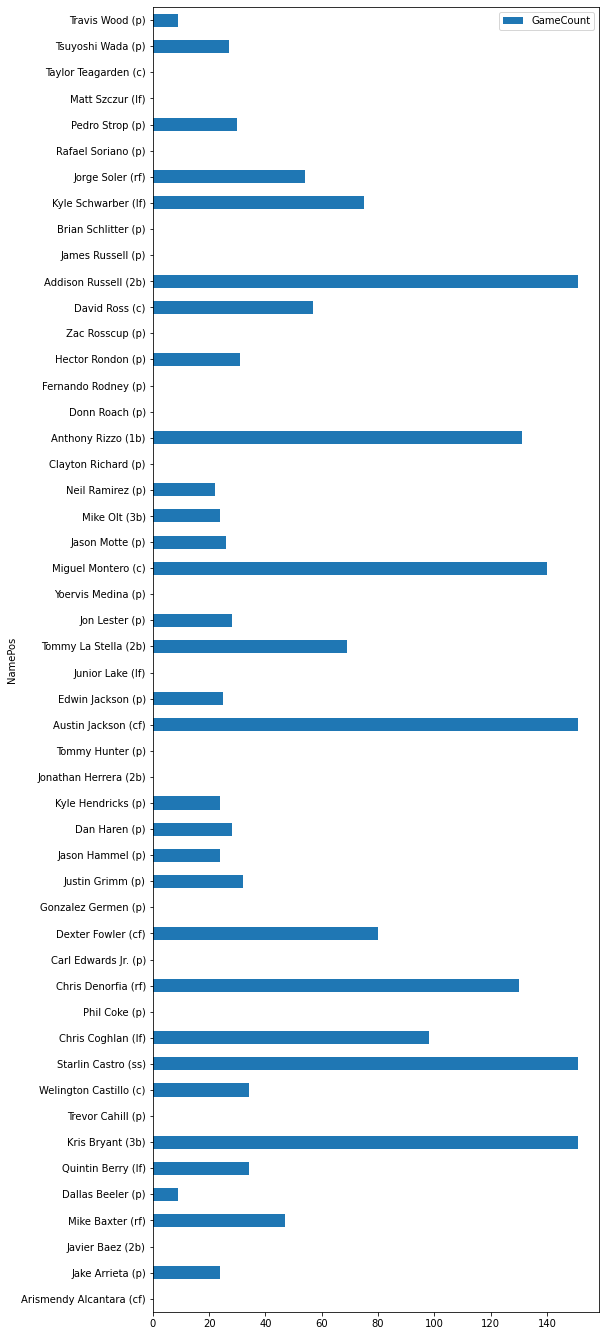

In [28]:
final_stat_df = pd.concat([cubs_fielders, cubs_sp, cubs_rp])[['playerID', 'Name', 'MainPos']]
final_stat_df['NamePos'] = final_stat_df.Name + ' (' + final_stat_df.MainPos + ')'

final_stat_df['GameCount'] = final_stat_df.apply(lambda row: get_games_played(row.playerID)[0], axis = 1)

final_stat_df.sort_values(by=['playerID']).plot.barh(x='NamePos', y='GameCount', figsize=(8,24))

In [46]:
final_stat_df.join(cubs_avg_stats[['WAR']].replace(np.inf, 50).replace(-np.inf,-50))[['playerID','Name','WAR','GameCount']]

,playerID,Name,WAR,GameCount
0,alcanar01,Arismendy Alcantara,0.183657,0.0
2,baezja01,Javier Baez,-0.166361,0.0
3,baxtemi01,Mike Baxter,0.164776,47.0
5,berryqu01,Quintin Berry,0.353005,34.0
6,bryankr01,Kris Bryant,6.098138,151.0
8,castiwe01,Welington Castillo,0.740666,34.0
9,castrst01,Starlin Castro,1.929982,151.0
10,coghlch01,Chris Coghlan,0.730845,98.0
12,denorch01,Chris Denorfia,1.251926,130.0
14,fowlede01,Dexter Fowler,2.414931,80.0


In [29]:
# final_player_stat_df['GameCount'] = final_stat_df.apply(lambda row: get_games_played(row.playerID)[0], axis = 1)

# final_player_stat_df.sort_values(by=['GameCount']).plot.barh(x='NamePos', y='GameCount', figsize=(8,24))

game_stats = []

for i in range(163):
  game_dict =  {fielder[1]: fielder[0] for fielder in who_fielded(i)}
  game_dict['p_s'] = who_started(i)[0]
  game_dict['p_r'] = who_relieved(i)[0][0]
  if len(who_relieved(i)) > 1:
    game_dict['p_r2'] = who_relieved(i)[1][0]
  
  game_stats.append(game_dict)

final_games_stat_df = pd.DataFrame(game_stats)

final_games_stat_df.describe()

,c,1b,2b,ss,3b,lf,rf,cf,p_s,p_r,p_r2
count,163,163,163,163,163,163,163,163,163,163,15
unique,3,4,3,2,3,6,3,2,7,7,5
top,Miguel Montero,Anthony Rizzo,Addison Russell,Starlin Castro,Kris Bryant,Chris Coghlan,Chris Denorfia,Austin Jackson,Dan Haren,Hector Rondon,Tsuyoshi Wada
freq,99,132,107,122,127,70,91,107,29,31,5


In [30]:
final_games_stat_df.head()

,c,1b,2b,ss,3b,lf,rf,cf,p_s,p_r,p_r2
0,Miguel Montero,Anthony Rizzo,Addison Russell,Starlin Castro,Kris Bryant,Chris Coghlan,Jorge Soler,Austin Jackson,Dan Haren,Jason Motte,NaN
1,Welington Castillo,Anthony Rizzo,Addison Russell,Starlin Castro,Kris Bryant,Chris Coghlan,Chris Denorfia,Dexter Fowler,Jason Hammel,Dallas Beeler,Justin Grimm
2,Miguel Montero,Anthony Rizzo,Addison Russell,Starlin Castro,Kris Bryant,Chris Denorfia,Mike Baxter,Dexter Fowler,Jake Arrieta,Neil Ramirez,NaN
3,Welington Castillo,Mike Baxter,Addison Russell,Starlin Castro,Kris Bryant,Chris Coghlan,Chris Denorfia,Austin Jackson,Edwin Jackson,Pedro Strop,NaN
4,Miguel Montero,Anthony Rizzo,Addison Russell,Starlin Castro,Kris Bryant,Austin Jackson,Mike Baxter,Dexter Fowler,Kyle Hendricks,Hector Rondon,NaN


In [31]:
position_freqs = []

for i in range(163):
  # add a dictionary (row) for each fielder
  {position_freqs.append(
      {'pos': fielder[1], 
       'player':fielder[0]}
       ) 
      for fielder in who_fielded(i)
    }

  # add a dict for starter
  position_freqs.append(
      {'pos': 'p_s',
       'player': who_started(i)[0]
      }
    )
  # add dict for reliever 1
  position_freqs.append(
      {'pos': 'p_r',
       'player': who_relieved(i)[0][0]
      }
    )
  
  # add dict for reliever 2
  if len(who_relieved(i)) > 1:
    position_freqs.append(
        {'pos': 'p_r',
        'player': who_relieved(i)[1][0]
        }
      )


final_pos_stat_df = pd.DataFrame(position_freqs)

final_pos_stat_df.describe()

,pos,player
count,1645,1645
unique,10,31
top,p_r,Addison Russell
freq,178,148


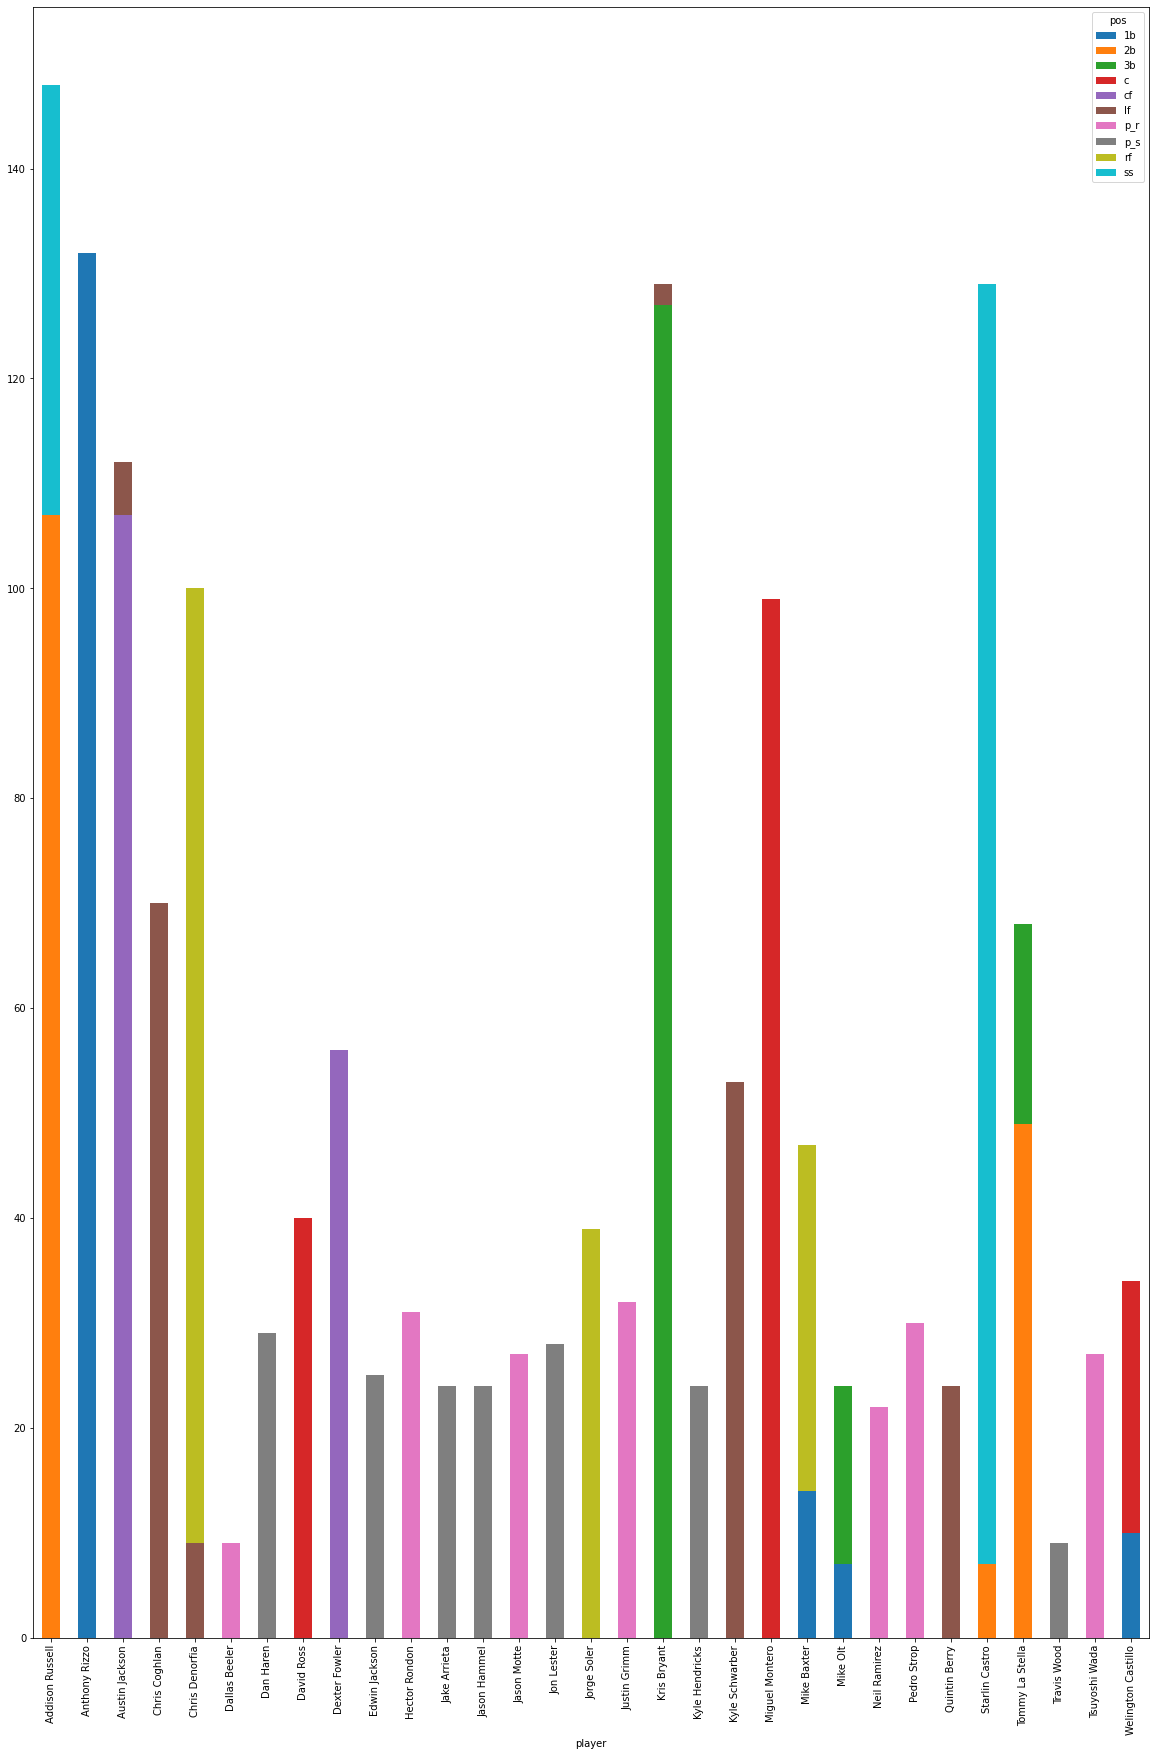

In [32]:
aggre = final_pos_stat_df.groupby(['player', 'pos'])['player'].agg('count')
aggre.unstack().plot.bar(stacked=True, figsize=(20,30))


# Export

In [33]:
# original data
cubs_avg_stats.to_pickle('cubs_avg_stats_DF.pkl')
# profile.to_file("your_report.html")  # large file


# solution results
cubs_fielders.to_pickle('cubs_fielders_DF.pkl')
cubs_sp.to_pickle('cubs_sp_DF.pkl')
cubs_rp.to_pickle('cubs_rp_DF.pkl')

# analysis data
final_stat_df.to_pickle('final_stat_DF.pkl')
final_games_stat_df.to_pickle('final_games_stat_DF.pkl')
final_pos_stat_df.to_pickle('final_pos_stat_DF.pkl')
